In [1]:
from IPython.display import clear_output
!git clone https://github.com/matterport/Mask_RCNN.git # load Mask R-CNN code implementation
 # load new data set and annotations 
!pip install pycocotools

!rm -rf brain-tumor/.git/
!rm -rf Mask_RCNN/.git/

clear_output()

In [2]:
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.13.1
!pip install tensorflow_estimator --force-reinstall
!pip install 'h5py==2.10.0' --force-reinstall
!pip install -U scikit-image==0.16.2
!pip install -U keras==2.1.0 --force-reinstall

Found existing installation: tensorflow 2.8.0+zzzcolab20220506162203
Uninstalling tensorflow-2.8.0+zzzcolab20220506162203:
  Successfully uninstalled tensorflow-2.8.0+zzzcolab20220506162203
     |████████████████████████████████| 345.0 MB 4.0 kB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 3.2 MB 4.4 MB/s 
     |████████████████████████████████| 367 kB 44.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
     |████████████████████████████████| 438 kB 15.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimato

     |████████████████████████████████| 26.5 MB 1.6 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 302 kB 27.5 MB/s 
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 596 kB 50.6 MB/s 
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempti

In [9]:
!pip install -U keras==2.1.0

  Using cached Keras-2.1.0-py2.py3-none-any.whl (302 kB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%tensorflow_version 1.x
from IPython.display import clear_output
import os 
import sys
from tqdm import tqdm
import cv2

import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random


# Root directory of the project
ROOT_DIR = os.path.abspath('/content/Mask_RCNN')
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white'

TensorFlow 1.x selected.


Using TensorFlow backend.


In [3]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # directory to save logs and trained model
# ANNOTATIONS_DIR = 'brain-tumor/data/new/annotations/' # directory with annotations for train/val sets
DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/Data cleaned' # directory with image data
DEFAULT_LOGS_DIR = 'logs'

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
class TumorConfig(Config):
    """Configuration for training on the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 10
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [6]:
class BrainScanDataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [7]:
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [8]:
# Training dataset.
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=15,
    layers='heads'
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/tumor_detector20220522T0926/mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

 1/10 [==>...........................] - ETA: 10:20 - loss: 6.9712 - rpn_class_loss: 0.1395 - rpn_bbox_loss: 6.5861 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 7:43 - loss: 5.1379 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 3.9651 - mrcnn_class_loss: 0.2122 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.7337         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 6:18 - loss: 5.1987 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 3.9308 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.2864 - mrcnn_mask_loss: 0.7431

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 5:14 - loss: 6.4940 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 5.4971 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.5573

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 4:18 - loss: 5.6674 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 4.5795 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.5700

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:23 - loss: 4.9430 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 4.0325 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.2483 - mrcnn_mask_loss: 0.4750

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:31 - loss: 4.8524 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 3.8893 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.2622 - mrcnn_mask_loss: 0.5312

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:40 - loss: 4.5093 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 3.4483 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 0.5620

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 49s - loss: 4.1443 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 3.0693 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.3598 - mrcnn_mask_loss: 0.5754 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted


10/10 [==============================] - 1281s 128s/step - loss: 4.2858 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 3.3045 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.5179 - val_loss: 3.3351 - val_rpn_class_loss: 0.1453 - val_rpn_bbox_loss: 2.3057 - val_mrcnn_class_loss: 0.0465 - val_mrcnn_bbox_loss: 0.4367 - val_mrcnn_mask_loss: 0.4009


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 2/15
 1/10 [==>...........................] - ETA: 7:18 - loss: 3.9285 - rpn_class_loss: 0.1481 - rpn_bbox_loss: 2.1927 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.7842 - mrcnn_mask_loss: 0.6407

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:27 - loss: 3.0311 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.3357 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.9081 - mrcnn_mask_loss: 0.6136

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:36 - loss: 2.5584 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.9527 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.7799 - mrcnn_mask_loss: 0.6043

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:46 - loss: 2.3852 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.7793 - mrcnn_class_loss: 0.1317 - mrcnn_bbox_loss: 0.8471 - mrcnn_mask_loss: 0.5833

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:57 - loss: 2.2888 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6762 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.8341 - mrcnn_mask_loss: 0.6176

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:10 - loss: 2.1988 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.6255 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.7990 - mrcnn_mask_loss: 0.6200

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:22 - loss: 2.1856 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.6035 - mrcnn_class_loss: 0.1300 - mrcnn_bbox_loss: 0.8042 - mrcnn_mask_loss: 0.6121

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:34 - loss: 2.0288 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.5361 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.7436 - mrcnn_mask_loss: 0.6023

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 47s - loss: 1.9482 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.4855 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.7289 - mrcnn_mask_loss: 0.5938 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1181s 118s/step - loss: 1.8826 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4536 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.6984 - mrcnn_mask_loss: 0.5872 - val_loss: 2.4066 - val_rpn_class_loss: 0.0942 - val_rpn_bbox_loss: 1.1604 - val_mrcnn_class_loss: 0.0632 - val_mrcnn_bbox_loss: 0.5946 - val_mrcnn_mask_loss: 0.4942


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 3/15
 1/10 [==>...........................] - ETA: 7:06 - loss: 1.5931 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.8941 - mrcnn_mask_loss: 0.4901

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:17 - loss: 1.7363 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.8847 - mrcnn_mask_loss: 0.4715

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:27 - loss: 1.6504 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2844 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.8405 - mrcnn_mask_loss: 0.4566

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:39 - loss: 1.5240 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.7531 - mrcnn_mask_loss: 0.4446

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:53 - loss: 1.3910 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.6663 - mrcnn_mask_loss: 0.4358

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:07 - loss: 1.5092 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2501 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.7265 - mrcnn_mask_loss: 0.4461

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:19 - loss: 1.4613 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0853 - mrcnn_bbox_loss: 0.7065 - mrcnn_mask_loss: 0.4353

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:33 - loss: 1.4987 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2350 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.7198 - mrcnn_mask_loss: 0.4434

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.5081 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.7280 - mrcnn_mask_loss: 0.4577 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1166s 117s/step - loss: 1.7255 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.3907 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.7587 - mrcnn_mask_loss: 0.4731 - val_loss: 2.0711 - val_rpn_class_loss: 0.0753 - val_rpn_bbox_loss: 0.7435 - val_mrcnn_class_loss: 0.0842 - val_mrcnn_bbox_loss: 0.6974 - val_mrcnn_mask_loss: 0.4707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 4/15
 1/10 [==>...........................] - ETA: 7:13 - loss: 1.7095 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.3684 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.7305 - mrcnn_mask_loss: 0.4690

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:17 - loss: 1.9344 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 0.5538 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.6779 - mrcnn_mask_loss: 0.5711

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:28 - loss: 1.5807 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.4125 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.5762 - mrcnn_mask_loss: 0.4847

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:42 - loss: 1.5569 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.3625 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.5872 - mrcnn_mask_loss: 0.5051

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:55 - loss: 1.4133 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.3177 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.5383 - mrcnn_mask_loss: 0.4720

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:08 - loss: 1.2996 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4975 - mrcnn_mask_loss: 0.4390

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:21 - loss: 1.2733 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.2462 - mrcnn_class_loss: 0.0672 - mrcnn_bbox_loss: 0.4922 - mrcnn_mask_loss: 0.4389

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:34 - loss: 1.3749 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.2771 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.5517 - mrcnn_mask_loss: 0.4592

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 47s - loss: 1.3616 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.2726 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.5643 - mrcnn_mask_loss: 0.4377 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1169s 117s/step - loss: 1.4231 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.2812 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.6042 - mrcnn_mask_loss: 0.4436 - val_loss: 1.7010 - val_rpn_class_loss: 0.0610 - val_rpn_bbox_loss: 0.5952 - val_mrcnn_class_loss: 0.0826 - val_mrcnn_bbox_loss: 0.5387 - val_mrcnn_mask_loss: 0.4236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 5/15
 1/10 [==>...........................] - ETA: 6:57 - loss: 2.4077 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 0.9491 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.8700 - mrcnn_mask_loss: 0.4822

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:10 - loss: 1.8689 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.5972 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.6949 - mrcnn_mask_loss: 0.4589

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:25 - loss: 1.7629 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.6232 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.6355 - mrcnn_mask_loss: 0.4136

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:39 - loss: 1.5999 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.4939 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.6350 - mrcnn_mask_loss: 0.3708

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:52 - loss: 1.6432 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.5236 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.6425 - mrcnn_mask_loss: 0.3785

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:06 - loss: 1.5462 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.4752 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.6167 - mrcnn_mask_loss: 0.3568

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:19 - loss: 1.6001 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4668 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.6738 - mrcnn_mask_loss: 0.3670

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:33 - loss: 1.5699 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.6543 - mrcnn_mask_loss: 0.3796

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.5586 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.4457 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.6227 - mrcnn_mask_loss: 0.3820 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1163s 116s/step - loss: 1.5726 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.4322 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.6278 - mrcnn_mask_loss: 0.3799 - val_loss: 1.6570 - val_rpn_class_loss: 0.0469 - val_rpn_bbox_loss: 0.5152 - val_mrcnn_class_loss: 0.0951 - val_mrcnn_bbox_loss: 0.6020 - val_mrcnn_mask_loss: 0.3978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 6/15
 1/10 [==>...........................] - ETA: 6:54 - loss: 1.5779 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.7809 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.2403

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:13 - loss: 1.3130 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.4478 - mrcnn_mask_loss: 0.2844

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:27 - loss: 1.2293 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.3569 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.4368 - mrcnn_mask_loss: 0.2905

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:40 - loss: 1.1470 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2935 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.4526 - mrcnn_mask_loss: 0.2868

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:53 - loss: 1.2233 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.3013 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.3243

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:06 - loss: 1.1667 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2621 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.4824 - mrcnn_mask_loss: 0.3061

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:19 - loss: 1.1399 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2647 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.4628 - mrcnn_mask_loss: 0.3042

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:33 - loss: 1.2135 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.3157 - mrcnn_class_loss: 0.0777 - mrcnn_bbox_loss: 0.4875 - mrcnn_mask_loss: 0.3085

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.2096 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.3059 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.4839 - mrcnn_mask_loss: 0.3191 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1163s 116s/step - loss: 1.1772 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.2928 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.4716 - mrcnn_mask_loss: 0.3172 - val_loss: 1.5414 - val_rpn_class_loss: 0.0444 - val_rpn_bbox_loss: 0.3902 - val_mrcnn_class_loss: 0.0789 - val_mrcnn_bbox_loss: 0.6512 - val_mrcnn_mask_loss: 0.3767


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 7/15
 1/10 [==>...........................] - ETA: 7:04 - loss: 1.3468 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1480 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.7515 - mrcnn_mask_loss: 0.3889

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:13 - loss: 1.2041 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1669 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.6060 - mrcnn_mask_loss: 0.3433

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:25 - loss: 1.1312 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.1509 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.5597 - mrcnn_mask_loss: 0.3386

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:39 - loss: 1.1015 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.1444 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.5306 - mrcnn_mask_loss: 0.3323

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:52 - loss: 1.0476 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.1450 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.5191 - mrcnn_mask_loss: 0.3032

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:05 - loss: 1.1274 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.1792 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.5556 - mrcnn_mask_loss: 0.3103

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:19 - loss: 1.0325 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1629 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.5099 - mrcnn_mask_loss: 0.2837

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:32 - loss: 1.1287 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1784 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.5803 - mrcnn_mask_loss: 0.2944

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.2057 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2112 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.6033 - mrcnn_mask_loss: 0.3112 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1158s 116s/step - loss: 1.2038 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2022 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.6194 - mrcnn_mask_loss: 0.3066 - val_loss: 1.6648 - val_rpn_class_loss: 0.0406 - val_rpn_bbox_loss: 0.4220 - val_mrcnn_class_loss: 0.0899 - val_mrcnn_bbox_loss: 0.7457 - val_mrcnn_mask_loss: 0.3667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 8/15
 1/10 [==>...........................] - ETA: 6:57 - loss: 1.8836 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 1.0855 - mrcnn_mask_loss: 0.5412

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:12 - loss: 1.1620 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.6675 - mrcnn_mask_loss: 0.3283

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:25 - loss: 1.1666 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.6214 - mrcnn_mask_loss: 0.3206

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:38 - loss: 1.2471 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.2759 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.5968 - mrcnn_mask_loss: 0.3170

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:52 - loss: 1.2655 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.3343

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:06 - loss: 1.3199 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.2429 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.6717 - mrcnn_mask_loss: 0.3511

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:19 - loss: 1.2932 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2542 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.6384 - mrcnn_mask_loss: 0.3411

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:33 - loss: 1.2993 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2571 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.6570 - mrcnn_mask_loss: 0.3232

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.3758 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2710 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.6984 - mrcnn_mask_loss: 0.3227 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1160s 116s/step - loss: 1.3664 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2700 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.6828 - mrcnn_mask_loss: 0.3233 - val_loss: 1.6804 - val_rpn_class_loss: 0.0409 - val_rpn_bbox_loss: 0.4984 - val_mrcnn_class_loss: 0.0847 - val_mrcnn_bbox_loss: 0.6764 - val_mrcnn_mask_loss: 0.3801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 9/15
 1/10 [==>...........................] - ETA: 6:59 - loss: 1.8080 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.5870 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.7302 - mrcnn_mask_loss: 0.3970

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:14 - loss: 1.3196 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.3661 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.2872

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:26 - loss: 1.1593 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.2769 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.5250 - mrcnn_mask_loss: 0.3113

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:40 - loss: 1.1244 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2475 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.5198 - mrcnn_mask_loss: 0.3066

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:52 - loss: 1.1563 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2589 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.5280 - mrcnn_mask_loss: 0.3140

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:06 - loss: 1.0699 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2357 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.4824 - mrcnn_mask_loss: 0.3014

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:19 - loss: 1.0349 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2440 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.4529 - mrcnn_mask_loss: 0.2841

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:32 - loss: 1.0010 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.4610 - mrcnn_mask_loss: 0.2671

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.0471 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.2895 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1166s 117s/step - loss: 1.0037 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.4482 - mrcnn_mask_loss: 0.2794 - val_loss: 1.5329 - val_rpn_class_loss: 0.0472 - val_rpn_bbox_loss: 0.5335 - val_mrcnn_class_loss: 0.0731 - val_mrcnn_bbox_loss: 0.5117 - val_mrcnn_mask_loss: 0.3674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 10/15
 1/10 [==>...........................] - ETA: 7:03 - loss: 0.6316 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.2948

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:15 - loss: 1.4793 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.7363 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.2828

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:29 - loss: 1.6545 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.7563 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.6044 - mrcnn_mask_loss: 0.2584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:40 - loss: 1.6621 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.6663 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.6739 - mrcnn_mask_loss: 0.2767

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:54 - loss: 1.6641 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6786 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.6594 - mrcnn_mask_loss: 0.2736

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:06 - loss: 1.5920 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.5852 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.6723 - mrcnn_mask_loss: 0.2771

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:20 - loss: 1.5365 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5322 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.6669 - mrcnn_mask_loss: 0.2666

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:33 - loss: 1.5113 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.5115 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.6465 - mrcnn_mask_loss: 0.2715

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.5000 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4801 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.6697 - mrcnn_mask_loss: 0.2664 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1162s 116s/step - loss: 1.4414 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4706 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.6290 - mrcnn_mask_loss: 0.2564 - val_loss: 1.6144 - val_rpn_class_loss: 0.0438 - val_rpn_bbox_loss: 0.5350 - val_mrcnn_class_loss: 0.0625 - val_mrcnn_bbox_loss: 0.6324 - val_mrcnn_mask_loss: 0.3407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 11/15
 1/10 [==>...........................] - ETA: 7:01 - loss: 1.7738 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.9021 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.2319

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:12 - loss: 1.5715 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.7128 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.5871 - mrcnn_mask_loss: 0.2236

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:26 - loss: 1.4210 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.5123 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.6059 - mrcnn_mask_loss: 0.2345

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:42 - loss: 1.2611 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4158 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.5663 - mrcnn_mask_loss: 0.2220

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:54 - loss: 1.2185 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.3552 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.5498 - mrcnn_mask_loss: 0.2325

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:07 - loss: 1.3952 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.3900 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.6103 - mrcnn_mask_loss: 0.2973

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:20 - loss: 1.4453 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.4561 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.6070 - mrcnn_mask_loss: 0.2962

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:33 - loss: 1.5544 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.7363 - mrcnn_mask_loss: 0.3063

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.5279 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.3942 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.7333 - mrcnn_mask_loss: 0.3162 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1167s 117s/step - loss: 1.5515 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.7710 - mrcnn_mask_loss: 0.3139 - val_loss: 1.5772 - val_rpn_class_loss: 0.0369 - val_rpn_bbox_loss: 0.5070 - val_mrcnn_class_loss: 0.0652 - val_mrcnn_bbox_loss: 0.6270 - val_mrcnn_mask_loss: 0.3411


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 12/15
 1/10 [==>...........................] - ETA: 7:10 - loss: 1.4233 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 1.3988 - mrcnn_class_loss: 3.4212e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:21 - loss: 0.8895 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.7537 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.0572            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:33 - loss: 0.9165 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.1334

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:44 - loss: 0.9604 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.3173 - mrcnn_mask_loss: 0.1560

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:56 - loss: 1.0518 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.4356 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.3586 - mrcnn_mask_loss: 0.1964

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:09 - loss: 0.9775 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.3883 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.1845

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:22 - loss: 0.9906 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.3651 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.3328 - mrcnn_mask_loss: 0.2023

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:34 - loss: 0.9590 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.3545 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.3259 - mrcnn_mask_loss: 0.1933

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 47s - loss: 0.9693 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.3365 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.3342 - mrcnn_mask_loss: 0.2108 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1170s 117s/step - loss: 0.9784 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.3469 - mrcnn_mask_loss: 0.2098 - val_loss: 1.3489 - val_rpn_class_loss: 0.0320 - val_rpn_bbox_loss: 0.4116 - val_mrcnn_class_loss: 0.0693 - val_mrcnn_bbox_loss: 0.4805 - val_mrcnn_mask_loss: 0.3555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 13/15
 1/10 [==>...........................] - ETA: 7:02 - loss: 0.5115 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.1363

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:14 - loss: 1.0541 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.5809 - mrcnn_mask_loss: 0.2389

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:28 - loss: 1.1241 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.5532 - mrcnn_mask_loss: 0.2740

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:41 - loss: 1.1484 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.2028 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.5622 - mrcnn_mask_loss: 0.3028

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:55 - loss: 1.1460 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.2316 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.5141 - mrcnn_mask_loss: 0.3249

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:07 - loss: 1.1230 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.2335 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.5114 - mrcnn_mask_loss: 0.3119

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:20 - loss: 1.1941 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.2530 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.5121 - mrcnn_mask_loss: 0.3449

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:33 - loss: 1.1552 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.2729 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.4796 - mrcnn_mask_loss: 0.3240

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 1.1225 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.2460 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.4931 - mrcnn_mask_loss: 0.3087 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1164s 116s/step - loss: 1.0773 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.4873 - mrcnn_mask_loss: 0.2899 - val_loss: 1.3698 - val_rpn_class_loss: 0.0348 - val_rpn_bbox_loss: 0.4828 - val_mrcnn_class_loss: 0.0643 - val_mrcnn_bbox_loss: 0.4553 - val_mrcnn_mask_loss: 0.3326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 14/15
 1/10 [==>...........................] - ETA: 7:06 - loss: 1.1224 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5401 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.2587

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:13 - loss: 1.1198 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4286 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.3431 - mrcnn_mask_loss: 0.2949

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:25 - loss: 1.0052 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4121 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 0.2383

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:38 - loss: 1.0840 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.4302 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.2806

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:52 - loss: 1.0931 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.4079 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.2510

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:06 - loss: 1.0201 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3920 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.3492 - mrcnn_mask_loss: 0.2293

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:19 - loss: 1.0777 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.3895 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.2664

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:32 - loss: 1.0060 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3474 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.2579

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 46s - loss: 0.9460 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3113 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.3394 - mrcnn_mask_loss: 0.2416 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1163s 116s/step - loss: 0.9605 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3293 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.2412 - val_loss: 1.5020 - val_rpn_class_loss: 0.0369 - val_rpn_bbox_loss: 0.5546 - val_mrcnn_class_loss: 0.0537 - val_mrcnn_bbox_loss: 0.5144 - val_mrcnn_mask_loss: 0.3425


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 15/15
 1/10 [==>...........................] - ETA: 6:52 - loss: 3.3044 - rpn_class_loss: 0.1428 - rpn_bbox_loss: 2.5444 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.2419

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 2/10 [=====>........................] - ETA: 6:16 - loss: 2.4070 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.4580 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.4717 - mrcnn_mask_loss: 0.2713

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 3/10 [========>.....................] - ETA: 5:27 - loss: 1.7612 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.0198 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.3637 - mrcnn_mask_loss: 0.2186

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 4/10 [===========>..................] - ETA: 4:40 - loss: 1.5010 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.7896 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.3627 - mrcnn_mask_loss: 0.2190

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 5/10 [==============>...............] - ETA: 3:54 - loss: 1.3136 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.3346 - mrcnn_mask_loss: 0.2043

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 6/10 [=================>............] - ETA: 3:08 - loss: 1.3993 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.6506 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.2210

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 7/10 [====================>.........] - ETA: 2:22 - loss: 1.3088 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.5752 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.4209 - mrcnn_mask_loss: 0.2192

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 8/10 [=======================>......] - ETA: 1:35 - loss: 1.3576 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.5759 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.4648 - mrcnn_mask_loss: 0.2330

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


 9/10 [==========================>...] - ETA: 47s - loss: 1.3210 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.5301 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.4533 - mrcnn_mask_loss: 0.2548 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

10/10 [==============================] - 1179s 118s/step - loss: 1.3890 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.5797 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.4517 - mrcnn_mask_loss: 0.2605 - val_loss: 1.3267 - val_rpn_class_loss: 0.0334 - val_rpn_bbox_loss: 0.4036 - val_mrcnn_class_loss: 0.0671 - val_mrcnn_bbox_loss: 0.4572 - val_mrcnn_mask_loss: 0.3653


In [9]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  logs/tumor_detector20220522T0926/mask_rcnn_tumor_detector_0015.h5
Re-starting from epoch 15


In [10]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)

In [11]:
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

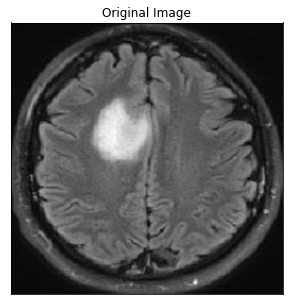

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


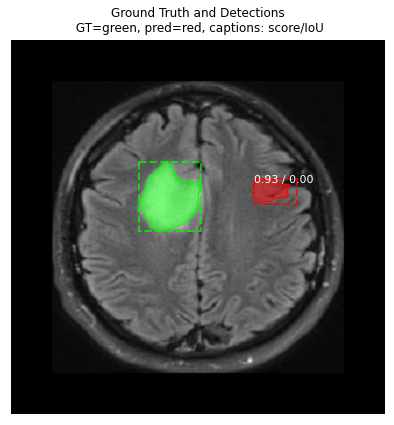

In [12]:
ind = 0
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

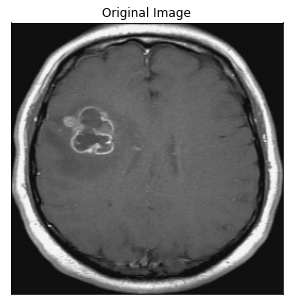

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


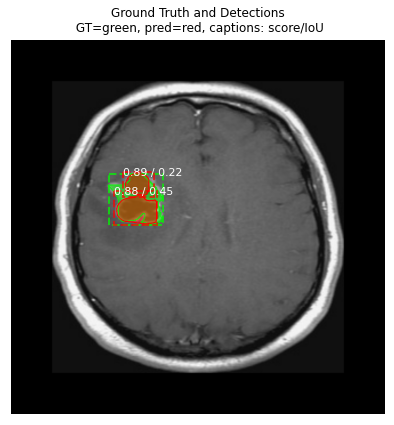

In [18]:
ind = 2
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

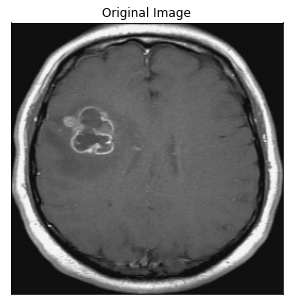

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


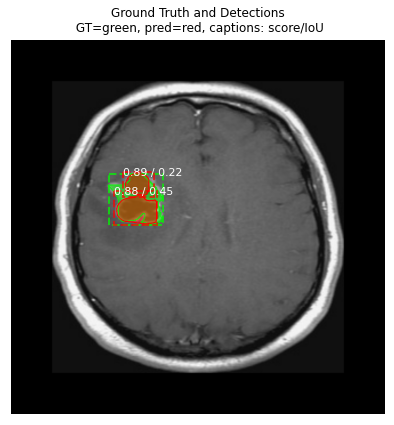

In [19]:
ind = 2
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

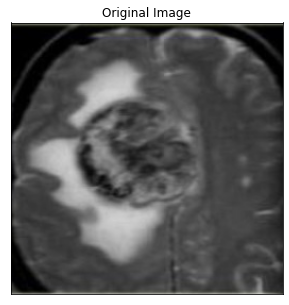

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


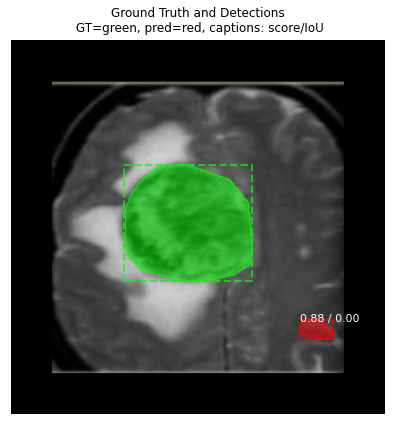

In [20]:
ind = 4
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

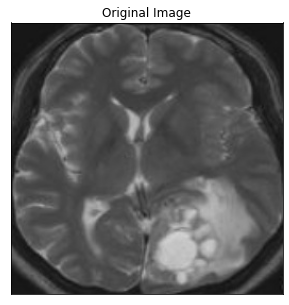

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


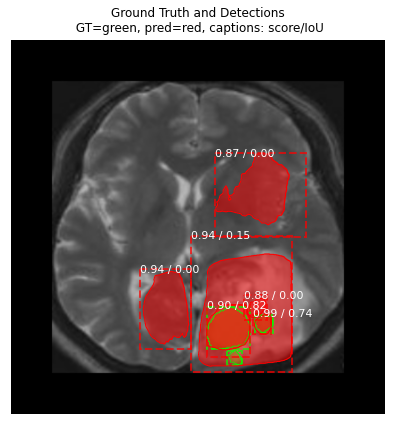

In [21]:
ind = 5
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

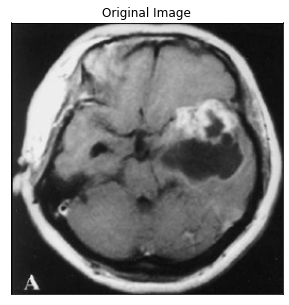

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


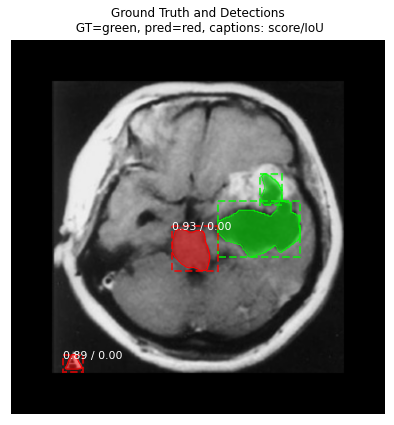

In [22]:
ind = 6
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

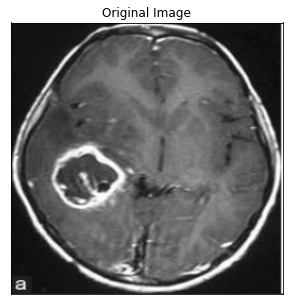

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


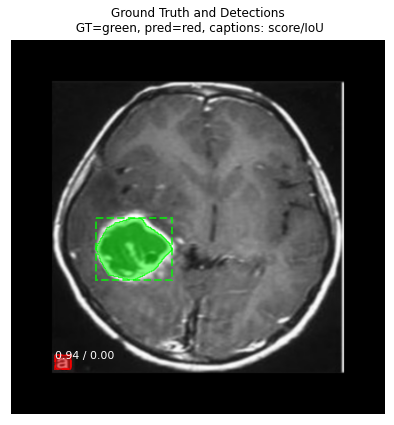

In [23]:
ind = 7
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

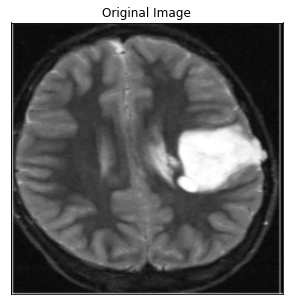

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


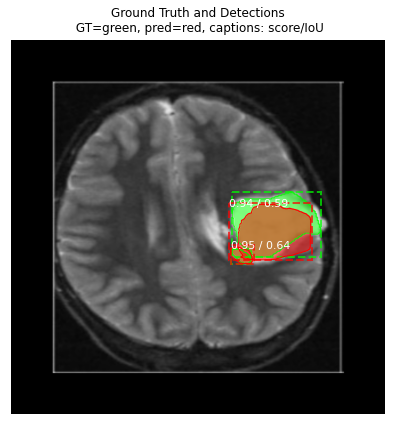

In [24]:
ind = 8
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

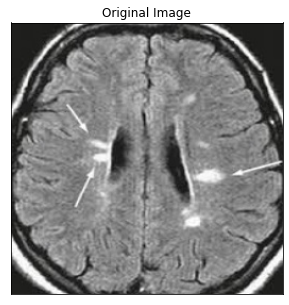

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


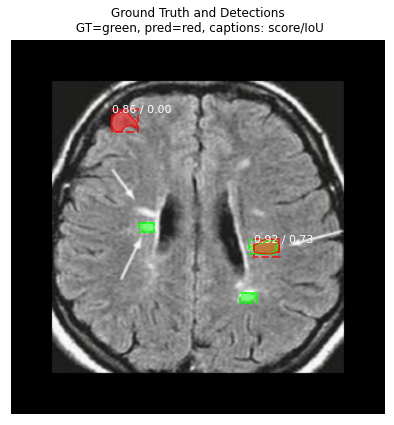

In [25]:
ind = 9
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

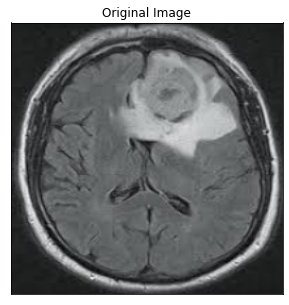

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


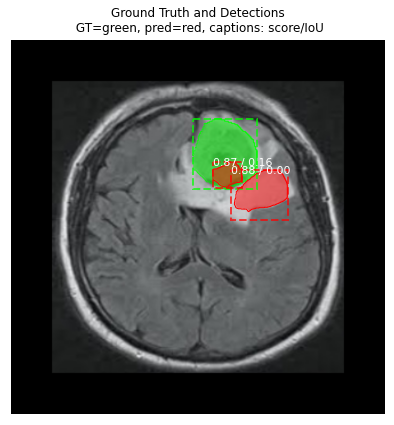

In [26]:
ind = 10
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

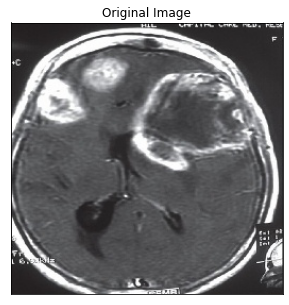

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


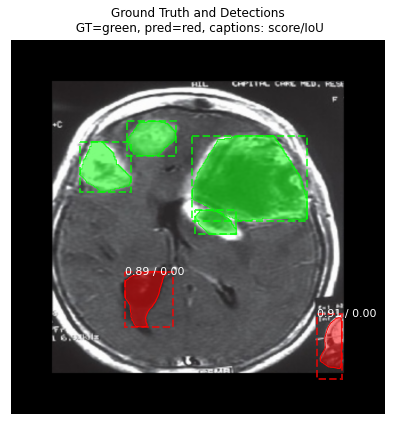

In [27]:
ind = 11
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

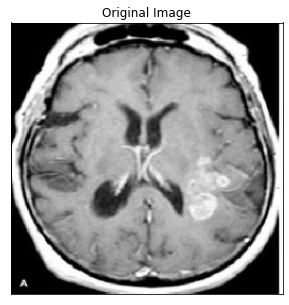

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


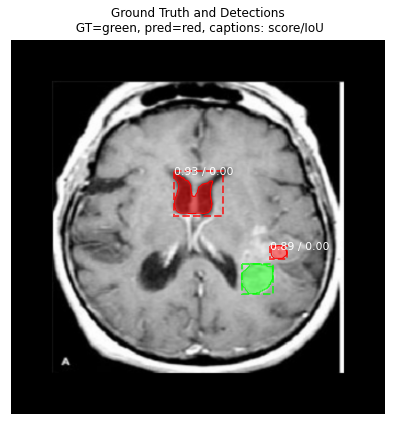

In [28]:
ind = 12
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

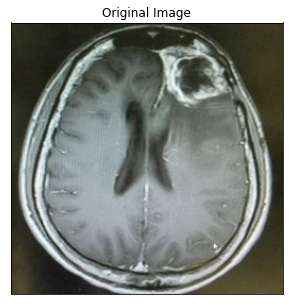

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


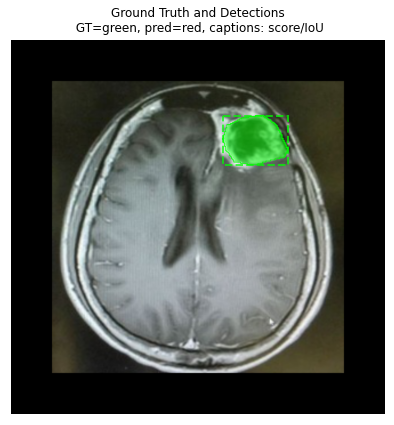

In [29]:
ind = 13
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

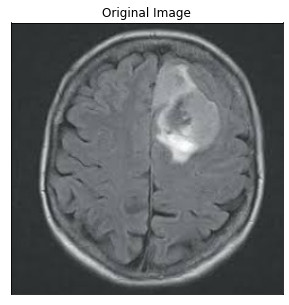

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


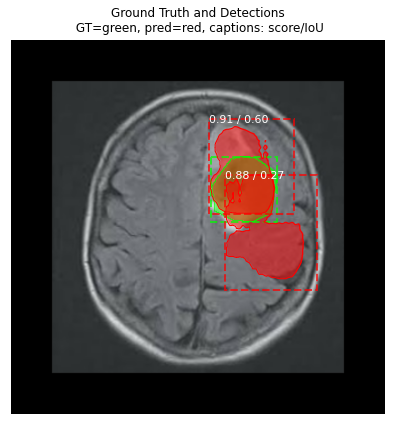

In [30]:
ind = 14
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

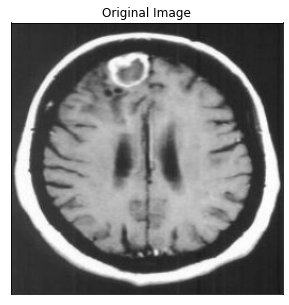

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


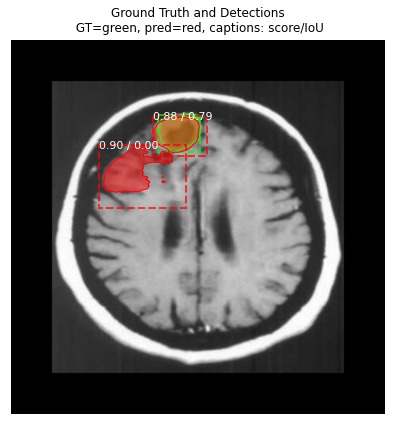

In [31]:
ind = 15
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

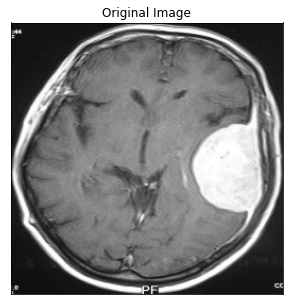

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


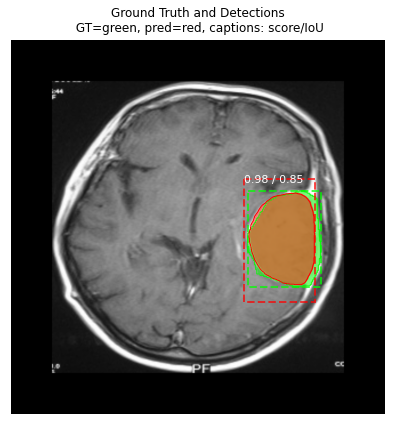

In [32]:
ind = 16
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

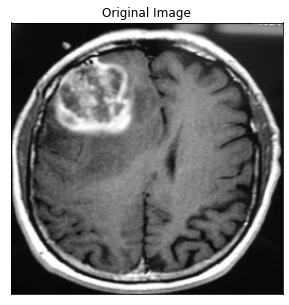

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


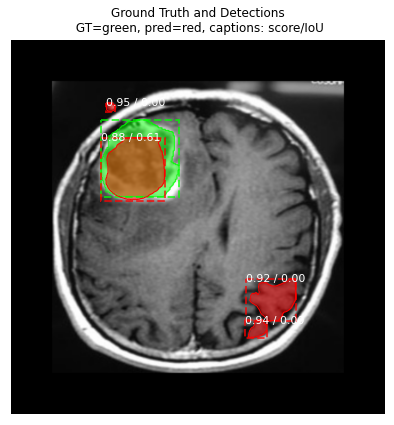

In [33]:
ind = 17
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

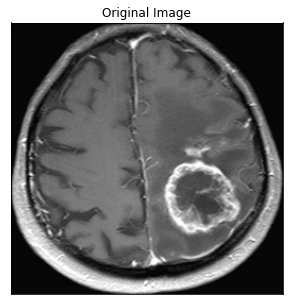

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


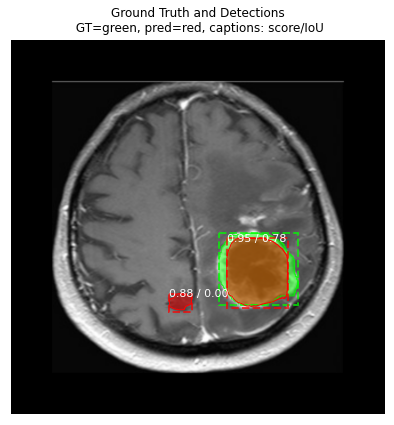

In [34]:
ind = 18
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

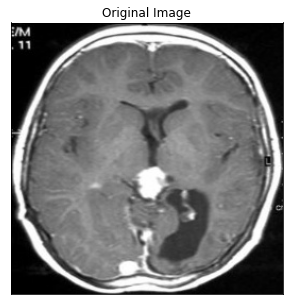

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


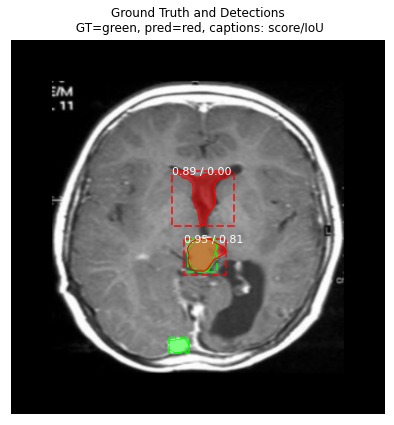

In [15]:
ind = 19
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)